Here we generate a simple and random one-dimensional dataset to fit with different polynomials and see how the test MSE behaves for multiple resamplings of the train dataset.

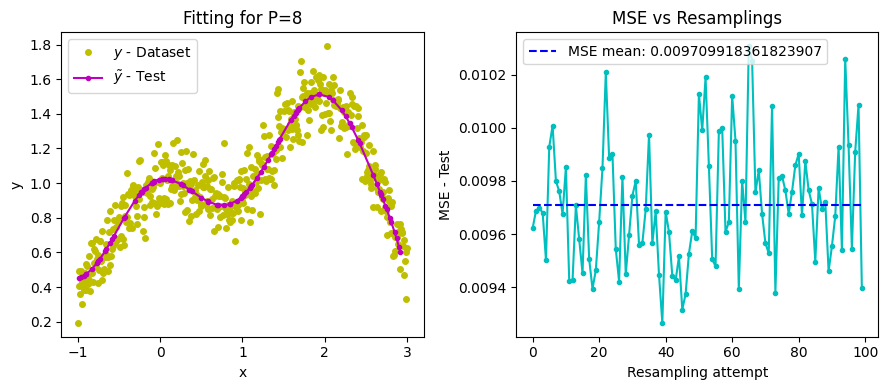

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

#DATASET
np.random.seed(100)
x = np.linspace(-1,3,500)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, len(x))

#Define MSE error
def MSE(y, y_tilde):
    return np.mean((y-y_tilde)**2)

#Create design matrix with P features
def designMatrix(x, P):
    X = np.zeros((len(x), P+1))
    for i in range(P+1):
        X[:,i] = x**i
    return X

#Define maximum features and batches
num_P = 8
num_batches = 100

#Store the MSE for different bootstraps
MSE_test_bootstrap = []

#Train-test splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#Loop
for k in range(num_batches):
  x_train_, y_train_ = resample(x, y)
  X_train = designMatrix(x_train_, num_P)
  beta_train = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train_
  X_test = designMatrix(x_test, num_P)
  y_tilde = X_test@beta_train
  MSE_test_bootstrap.append(MSE(y_test, y_tilde))


#Plotting
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(9, 4))

#Data sorting
data = np.stack((x_test,y_tilde), axis=1)
data = data[np.argsort(data[:,0])]
x_test_ = data[:,0]
y_tilde_ = data[:,1]

#Plot dataset
ax1.plot(x, y, 'yo', ms=4)
ax1.plot(x_test_, y_tilde_, 'mo-', ms=3)
ax1.legend([r'$y$ - Dataset', r'$\tilde{y}$ - Test'])
ax1.set_title(f'Fitting for P={num_P}')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

#Plot MSE vs batches
ax2.plot(MSE_test_bootstrap, "co-", ms=3)
ax2.plot([np.mean(MSE_test_bootstrap)]*len(MSE_test_bootstrap), "b--", label=f'MSE mean: {np.mean(MSE_test_bootstrap)}')
ax2.legend()
ax2.set_title('MSE vs Resamplings')
ax2.set_xlabel('Resampling attempt')
ax2.set_ylabel('MSE - Test')

plt.tight_layout()
plt.show()


In this second part, we perform the same analysis as before but looping over the polynomial degrees. Here we ignore the train-test splitting. For the bootstraping, we store all the resampled data in a 2-dim array in order to take the average over the resampled sets and save the MSE, bias and variance for each polynomial degree.  

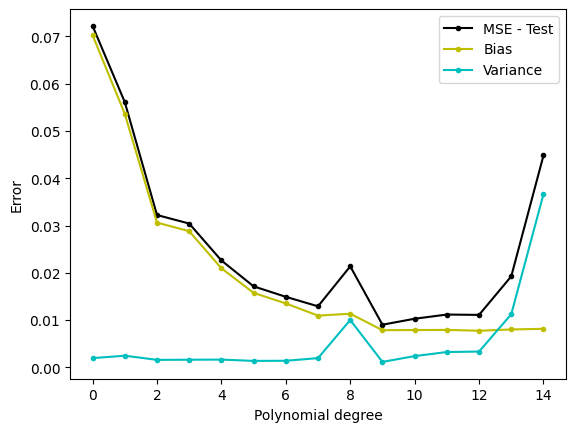

In [6]:
#DATASET
n_samples = 100
np.random.seed(100)
x = np.linspace(-3,3,n_samples)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, len(x))

#Define MSE, bias and var errors
def MSE(y, y_tilde):
  return np.mean((y-y_tilde)**2)

def bias(y, y_tilde):
  return np.mean((y - np.mean(y_tilde, axis=0))**2)

def var(y_tilde):
  return np.mean(np.var(y_tilde, axis=0))

#Values
max_poly = 16
num_batches = 150

#MSE errors as function of complexity
MSE_test = []
bias_test = []
var_test = []

#Loop for several poly degrees
for P in range(1, max_poly):

  #Store the MSE for different bootstraps
  MSE_test_bootstrap = []
  y_bootstrap = np.zeros((num_batches, n_samples))

  #Loop for bootstraping
  for k in range(num_batches):
    x_, y_ = resample(x, y, n_samples=len(x), replace=True)
    X_ = designMatrix(x_, P)
    betas = np.linalg.inv(X_.T@X_)@X_.T@y_
    y_tilde = designMatrix(x, P)@betas
    y_bootstrap[k] = y_tilde
    MSE_test_bootstrap.append(MSE(y, y_tilde))

  #Store MSE, bias and var
  MSE_test.append(np.mean(MSE_test_bootstrap))
  bias_test.append(bias(y, y_bootstrap))
  var_test.append(var(y_bootstrap))

#Plotting
plt.plot(MSE_test, "ko-", ms=3)
plt.plot(bias_test, "yo-", ms=3)
plt.plot(var_test, "co-", ms=3)
plt.xlabel('Polynomial degree')
plt.ylabel('Error')
plt.legend([r'MSE - Test', r'Bias', r'Variance'])
plt.plot()
plt.show()


In this final part, we try to reproduce the Figure 7.1 from Hastie et al Chapter 7. Here  we compute and plot the test MSE for every bootstraping resamples as a function of the model complexity in order to visualize and understand bias-variance tradeoff

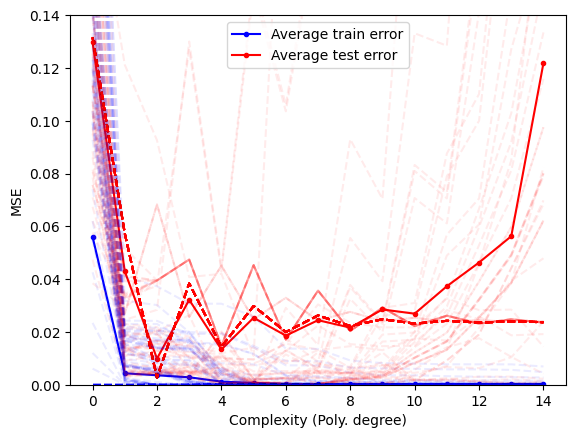

In [7]:
#DATASET
n_samples = 100
np.random.seed(100)
x = np.linspace(-3,3,n_samples)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, len(x))

#Values
max_poly = 15
num_batches = 150

#MSE errors as function of complexity
MSE_train = np.zeros((num_batches, max_poly))
MSE_test = np.zeros((num_batches, max_poly))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for k in range(num_batches):
  #Resampling
  x_train, y_train = resample(x_train, y_train, n_samples=len(x_train), replace=True)
  x_test, y_test = resample(x_test, y_test, n_samples=len(x_test), replace=True)

  #Define errors
  sqerror_train = []
  sqerror_test = []

  #Loop for several poly degrees
  for p in range(max_poly):

    #Create the design matrix X
    X_train = designMatrix(x_train, p)
    X_test = designMatrix(x_test, p)

    #Optimal values
    betas = (np.linalg.inv(X_train.T @ X_train + 0.001*np.eye(p+1)) @ X_train.T ) @ y_train

    #Make predictions
    y_tilde_train = X_train @ betas
    y_tilde_test = X_test @ betas

    sqerror_train.append(MSE(y_train, y_tilde_train))
    sqerror_test.append(MSE(y_test, y_tilde_test))

  MSE_train[k] = sqerror_train
  MSE_test[k] = sqerror_test

#Total average
MSE_train_av = np.mean(MSE_train, axis=0)
MSE_test_av = np.mean(MSE_test, axis=0)

#Plotting
plt.plot(MSE_train_av, "bo-", ms=3, label="Average train error")
plt.plot(MSE_test_av, "ro-", ms=3, label="Average test error")
for k in range(num_batches):
  plt.plot(MSE_train[k], "b--", alpha=0.08)
  plt.plot(MSE_test[k], "r--", alpha=0.08)
plt.legend(loc="upper center")
plt.ylim(0,0.14)
plt.xlabel('Complexity (Poly. degree)')
plt.ylabel('MSE')
plt.plot()
plt.show()


## Refs

The dataset used during the calculations was taken from the lecture notes https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/chapter3.html#the-bias-variance-tradeoff

For the Bootstraping resampling analysis, was used Hastie et al Chapter 7.11 and Figure 7.1 https://link.springer.com/book/10.1007/978-0-387-84858-7.